# Classifying Cars, Motorbikes, and cows

This notebook is models after the Dogs-Cats classifier in lesson 1 of the fast.ai curriculum.  A few methods have had to have been changed here in there to display data with more than two categories.  The database is of sideviews of cars, motorbikes, and cows from TUDArmstadt, and it can be found here http://host.robots.ox.ac.uk/pascal/VOC/databases.html#TUD.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/TUDarmstadt/PNGImages/"
sz=224 # size of the images
torch.backends.cudnn.enabled # should return true

True

In [4]:
!ls ~/data/TUDarmstadt

Annotations  GTMasks  PNGImages  results  test	train  valid


### Structure directories
Take data downloaded from TUDarmstadt and seperate it into training, testing, and validation sets.

In [5]:
# Note that throughout this block, the magic commands to the shell will automatically expand paths like ~/path/to/directory, where python won't
# but python won't for either ~ or variables like $HOME, which is why we need to get the absolute path
import os, sys
from os.path import expanduser, expandvars

current_dir = os.getcwd()
DATA_HOME_DIR_REL = "~/data/TUDarmstadt" 
DATA_HOME_DIR = expandvars(expanduser(DATA_HOME_DIR_REL))

%cd $DATA_HOME_DIR
DATA_HOME_DIR
current_dir

/home/paperspace/data/TUDarmstadt


'/home/paperspace/fastai/courses/dl1'

In [6]:

%cd $DATA_HOME_DIR
from glob import glob
import random
# Want to partition the images w/ same percentage for each class
# sideviews-cars, sideviews-cows2, motobike-testset
test_size = 0.2
validation_size = 0.2
train_size = 0.6

%mkdir valid
%mkdir results
%mkdir train
%mkdir test
%cd $DATA_HOME_DIR/PNGImages/
categories = os.listdir();

for category in categories:
    %cd $category
    category_images = glob('*.png')
    training = random.sample(category_images, int(train_size*len(category_images)))
    not_training = [item for item in category_images if item not in training]
    testing = random.sample(not_training, int(test_size*len(category_images)))
    validation = [item for item in not_training if item not in testing]
    %mkdir $DATA_HOME_DIR/valid/$category/
    %mkdir $DATA_HOME_DIR/test/$category/
    %mkdir $DATA_HOME_DIR/train/$category/

    if len(os.listdir(DATA_HOME_DIR + '/valid/' + category + '/')) == 0:
        for file in validation:
            %cp $file $DATA_HOME_DIR/valid/$category
    else:
        print("Already populated.")
    if len(os.listdir(DATA_HOME_DIR + '/train/' + category + '/')) == 0:
        for file in training:
            %cp $file $DATA_HOME_DIR/train/$category
        else:
            print("Already populated.")
    if len(os.listdir(DATA_HOME_DIR + '/test/' + category + '/')) == 0:
        for file in testing:
            %cp $file $DATA_HOME_DIR/test/$category
        else:
            print("Already populated.")
    %cd ..
cars = glob('*.png')

# cars_training = random.sample(cars, int(train_size*len(cars)))
# cars_not_training = [item for item in cars if item not in cars_training]
# cars_testing = random.sample(cars_not_training, int(test_size*len(cars)))
# cars_validation = [item for item in cars_not_training if item not in cars_testing]


/home/paperspace/data/TUDarmstadt
mkdir: cannot create directory ‘valid’: File exists
mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
/home/paperspace/data/TUDarmstadt/PNGImages
/home/paperspace/data/TUDarmstadt/PNGImages/sideviews-cows2
mkdir: cannot create directory ‘/home/paperspace/data/TUDarmstadt/valid/sideviews-cows2/’: File exists
mkdir: cannot create directory ‘/home/paperspace/data/TUDarmstadt/test/sideviews-cows2/’: File exists
mkdir: cannot create directory ‘/home/paperspace/data/TUDarmstadt/train/sideviews-cows2/’: File exists
Already populated.
/home/paperspace/data/TUDarmstadt/PNGImages
/home/paperspace/data/TUDarmstadt/PNGImages/sideviews-cars
mkdir: cannot create directory ‘/home/paperspace/data/TUDarmstadt/valid/sideviews-cars/’: File exists
mkdir: cannot create directory ‘/home/paperspace/data/TUDarmstadt/test/sideviews-cars/’: File exists
mkdir: cannot create

In [7]:
%cd $DATA_HOME_DIR
os.listdir('valid/sideviews-cars/')

/home/paperspace/data/TUDarmstadt


['car-pic128-sml.png',
 'car-pic147-sml2.png',
 'car-pic157-sml2.png',
 'car-pic147-sml.png',
 'car-pic131-sml-lt.png',
 'redcar005-01-sml-lt.png',
 'car-pic139-sml.png',
 '29060-sml2.png',
 '354072-sml.png',
 '29092-sml-lt.png',
 'car-pic165-sml2.png',
 'car-pic121-sml.png',
 'car-pic117-sml.png',
 'car-pic97-sml.png',
 'car-pic130-sml2.png',
 'sportscar2-sml-lt.png',
 'car-pic109-sml.png',
 'car-pic111-sml2.png',
 'car-pic22-sml-lt.png',
 'car-pic60-sml-lt.png']

['cow-pic151-sml-lt.png', 'cow-pic521-sml-lt.png', 'cow-pic131-sml-lt.png', 'cow-pic191-sml-lt.png', 'cow-pic211-sml-lt.png']
['cow-pic151-sml-lt.png', 'cow-pic521-sml-lt.png', 'cow-pic131-sml-lt.png', 'cow-pic191-sml-lt.png', 'cow-pic211-sml-lt.png']


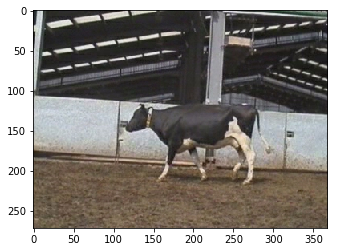

In [8]:
files = os.listdir('valid/sideviews-cows2')[:5]
print(files)
img = plt.imread(f'valid/sideviews-cows2/{files[0]}')
plt.imshow(img);
print(files)

In [ ]:
img[:3,:3]

### First Model

Use the pre-trained resnet34 model.

In [9]:
%pwd

'/home/paperspace/data/TUDarmstadt'

In [11]:
arch=resnet34
data = ImageClassifierData.from_paths("/home/paperspace/data/TUDarmstadt/", tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      1.29783    0.255071   0.976562  
    1      0.704438   0.028314   0.992188        



[0.028313683, 0.9921875]

In [12]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [13]:
data.classes

['motorbike-testset', 'sideviews-cars', 'sideviews-cows2']

In [14]:
log_preds = learn.predict()
log_preds.shape

(66, 3)

In [15]:
preds = np.argmax(log_preds, axis=1)
motorbike_probs = np.exp(log_preds[:,0])
cars_probs = np.exp(log_preds[:,1])
cows_probs = np.exp(log_preds[:,2])

log_preds[:10]

probs = np.exp(log_preds[:])
probs

array([[0.99601, 0.00135, 0.00264],
       [0.95406, 0.03302, 0.01292],
       [0.82339, 0.13272, 0.0439 ],
       [0.86765, 0.10706, 0.02529],
       [0.94477, 0.01842, 0.03681],
       [0.99217, 0.00609, 0.00173],
       [0.99679, 0.00222, 0.00099],
       [0.98542, 0.00971, 0.00487],
       [0.98631, 0.00504, 0.00865],
       [0.97924, 0.01627, 0.00449],
       [0.9615 , 0.02296, 0.01554],
       [0.91922, 0.05768, 0.0231 ],
       [0.98213, 0.01092, 0.00694],
       [0.7686 , 0.10214, 0.12926],
       [0.85334, 0.13087, 0.01579],
       [0.90227, 0.08439, 0.01334],
       [0.9761 , 0.0161 , 0.0078 ],
       [0.99447, 0.00304, 0.00249],
       [0.94237, 0.04561, 0.01201],
       [0.9839 , 0.00642, 0.00967],
       [0.97262, 0.02374, 0.00364],
       [0.98217, 0.00827, 0.00956],
       [0.95355, 0.03697, 0.00949],
       [0.04203, 0.94087, 0.0171 ],
       [0.01874, 0.97163, 0.00963],
       [0.00793, 0.97993, 0.01214],
       [0.03129, 0.95897, 0.00973],
       [0.01786, 0.97846, 0.

In [16]:
preds == data.val_y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [49]:
### HAVE TO MODIFY THESE FUNCTIONS FOR MULTIPLE CLASSES

# np.where with the mask returns *indices* for nonzero elements of the mask 
# np.where(mask)[0] takes the only the row indices
# np.random.choice picks the first four of these (or 2)
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

# This function doesn't need to be changed to work with n > 2 classes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Got to turn probs[x], which is an array, into a string
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [', '.join([str('%.2f' % p) for p in probs[x]]) for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

## What's the difference between this and the above fnt of the same name?
# def plot_val_with_title(idxs, title):
#     imgs = [load_img_id(data.val_ds,x) for x in idxs]
#     title_probs = [probs[x] for x in idxs]
#     print(title)
#     return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Incorrectly classified


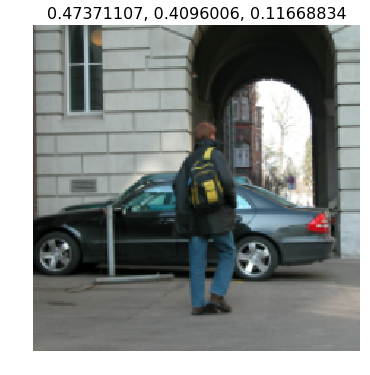

In [20]:
#incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")
#If nothing is incorrectly classified, this will give an error!



In the image above, we can see that the learner could recognize a person standing about where a person would be relative to a motorbike by the car.

Most correct cows
Most correct cars
Most correct motorbikes


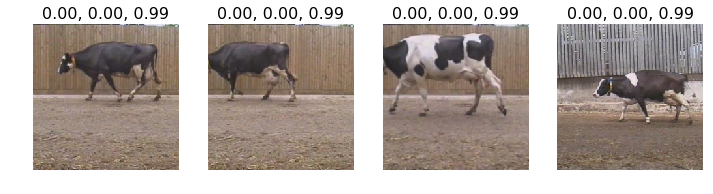

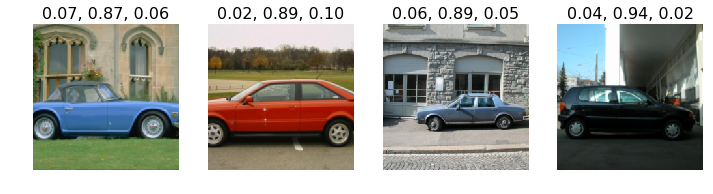

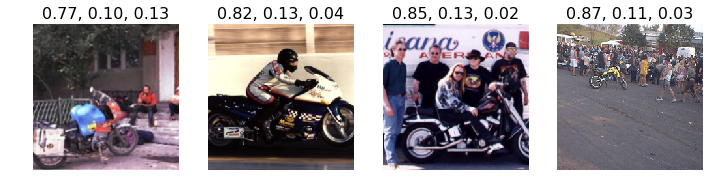

In [50]:
def most_by_mask(mask, category_id):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(probs[idxs][:,category_id])[:4]]

def most_by_correct(y, is_correct): 
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y)

# most_by_mask(, mult):


is_correct=True
y=2
mask = ((preds == data.val_y)==is_correct) & (data.val_y == y)
idxs = np.where(mask)[0]
probs[idxs][:,2]

most_by_correct(2, True)

# most_by_correct(0, False)
plot_val_with_title(most_by_correct(2, True), "Most correct cows")
plot_val_with_title(most_by_correct(1, True), "Most correct cars")
plot_val_with_title(most_by_correct(0, True), "Most correct motorbikes")


# Can't do this if we don't have enough incorrect motorbikes
# plot_val_with_title(most_by_correct(0, False), "Most incorrect motorbike")

Interesting to see here that most correct cars choose both cows and motorbikes as their runner up choice.  Also, the learner is most certain about classifying its cows!  This is not surprising, since as noted in the description of the dataset:
> - All cows have roughly the same scale and orientation (side view, facing left)
> - The 111 cow images have only 3 distinct backgrounds and many of the cow images are quite similar to at least one other cow image in the database 

In [51]:
# Ok, we can save the layer here for doing stuff with it later!
learn.save('224_cowscarsbikes')

# To load it
# learn.load('224_cowscarsbikes')